In [1]:
include("source.jl")
include("NS_FVM_solver.jl")
using JLD
training_data_path = "data/KF/training_data.jld"

using Plots

# Navier stokes equations

In this notebook we consider the incompressible forced Navier-Stokes equations

$$ \frac{\partial \mathbf{u}}{\partial t} = - (\mathbf{u} \cdot \nabla)\mathbf{u} + \frac{1}{\text{Re}}\nabla^2\mathbf{u} -\nabla p + \mathbf{F} \\
\nabla \cdot \mathbf{u} = 0
$$

for $\mathbf{u} = \begin{bmatrix} u & v \end{bmatrix}^T$. We consider Kolmogorov Flow in 2D with periodic boundary condtions. In this case the forcing is defined as

$$ \mathbf{F} = \begin{bmatrix}{\sin(4y)} \\ 0 \end{bmatrix} - 0.1 \mathbf{u}.$$

Training data is obtained by running the generate_KF_data.jl script.

## Load training data

In [2]:
t_data, sim_data, F = (load(training_data_path)[i] for i in ("t","V","F"))
0

0

## Initialize meshes and define compression factor

In [3]:
N = size(sim_data)[1:2]
UPC = size(sim_data)[3]        


x= collect(LinRange(-pi,pi,N[1]+1))
y = collect(LinRange(-pi,pi,N[2]+1))

fine_mesh = gen_mesh(x,y,UPC = UPC)

# number of unknowns per cell

J = (16,16) # compression in each direction
coarse_mesh = gen_coarse_from_fine_mesh(fine_mesh,J)
MP = gen_mesh_pair(fine_mesh,coarse_mesh)
0



┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = ConvTranspose((16, 16), 2 => 2, stride=16, bias=false)  # 1_024 parameters
│   summary(x) = "16×16×2×1 Array{Float64, 4}"
└ @ Flux ~/.julia/packages/Flux/jgpVj/src/layers/stateless.jl:60


0

## Generate the operators used to solve Navier-Stokes

In [4]:
setup = gen_setup(fine_mesh)
0

0

## Compute vorticity of the DNS and display

The voriticity $\omega$ is computed as 


$$\omega = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y} $$.

[ Info: Saved animation to /home/toby/Projects/Local_POD_NS/DNS_flow.gif


Plots.AnimatedGif("/home/toby/Projects/Local_POD_NS/DNS_flow.gif")
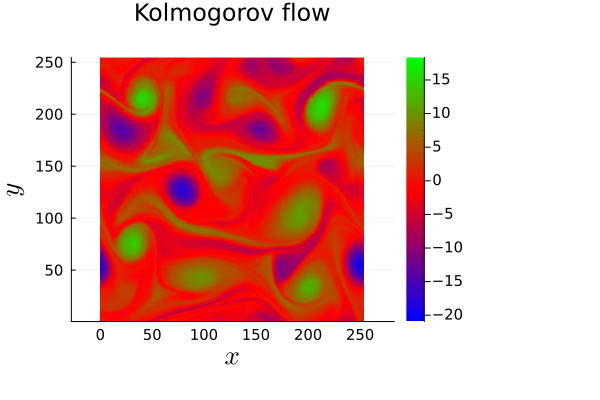

In [5]:
to_plot = setup.O.w(sim_data[:,:,:,1,1:50])[:,:,1,:]

ymin = minimum(to_plot)
ymax = maximum(to_plot)


anim = @animate for index in 1:size(to_plot)[3]
    Plots.heatmap(to_plot[:,:,index]',color = :brg,clim = (ymin,ymax),yflip=false,xtickfontsize = 10,ytickfontsize = 10
    ,aspect_ratio = :equal,titlefontsize=16,yguidefontsize=18,xguidefontsize=18,title = "Kolmogorov flow",right_margin = 35Plots.mm)
    Plots.xlabel!(L"x")
    Plots.ylabel!(L"y")
    #title!(L"t = " * string(round(example_t[index],digits = 1)))
end

gif(anim, "DNS_flow.gif", fps = 30)

## Energy trajectory of the DNS

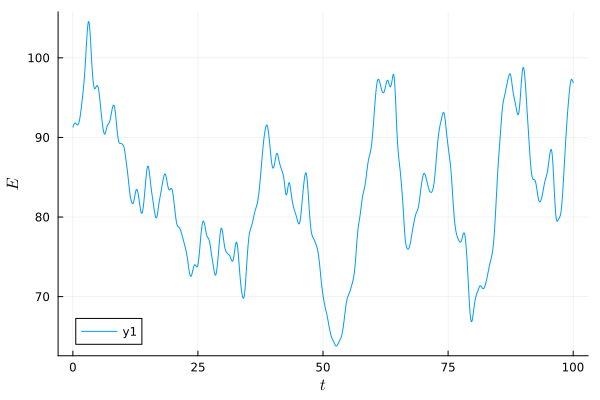

In [6]:
energies = fine_mesh.ip(sim_data,sim_data)
plot(t_data[:,:,:,1,:][1:end],energies[:,:,:,1,:][1:end])
xlabel!(L"t")
ylabel!(L"E")

# Filtering and local POD

Let us assume the DNS solution $\mathbf{u}$ is a continuous solution in $\mathbb{R}^2$. Our aim is to model the behaviour of $\mathbf{u}$ on a coarser grid. For this purpose we divide the computational domain $\Omega$ in a set of $I$ non-overlapping coarse grid cells $\Omega_i$. Next, let us assume we can express $\mathbf{u}$ as a weighted sum of orthonormal local basis functions $\boldsymbol{\phi}_{ij}(\mathbf{x}) \in \mathbb{R}^2$ living within the coarse grid cell $\Omega_i$:

$$\mathbf{u}(t,\mathbf{x}) = \sum^{IJ}_{ij} b_{ij}(t)\boldsymbol{\phi}_{ij}(\mathbf{x}). $$

The basis functions $\boldsymbol{\phi}_{ij}(\mathbf{x})$ are associated only with coarse grid cell $\Omega_i$ and are zero everywhere else. Furthermore, each coarse cell is associated with $J$ basis functions. This can for example be a finite element basis. 
The important part is that the basis functions are constructed in a consistent fashion for each cell. As the first two basis function we always choose

$$ \boldsymbol{\phi}_{i1}(\mathbf{x}) = \begin{bmatrix} 1 \\ 0 \end{bmatrix}, \quad \boldsymbol{\phi}_{i2}(\mathbf{x}) = \begin{bmatrix} 0 \\ 1 \end{bmatrix}.$$

These capture the momentum of the system:

$$\mathbf{P}_i := \int_{\Omega_i} \mathbf{u}\text{d}\Omega = \int_{\Omega_i} b_{i1} \boldsymbol{\phi}_{i1} + b_{i2} \boldsymbol{\phi}_{i2}\text{d}\Omega = |\Omega_i| \begin{bmatrix} b_{i1} \\ b_{i2} \end{bmatrix}, 
\quad \mathbf{P} = \sum_i^I \mathbf{P}_i.$$



The coefficients $b_{ij}$ are obtained by computing the following inner-product:

$$b_{ij}(t) = \frac{1}{|\Omega_i|}\int_{\Omega_i} \mathbf{u}(t,\mathbf{x})\cdot \boldsymbol{\phi}_{ij}(\mathbf{x})\text{d}\Omega.$$

Note that this basis typically has to be quite large to capture all the details of the DNS.

The aim of the local POD is to obtain a smaller, more specialized, basis $\boldsymbol{\psi}_{ik}(\mathbf{x}) \in \mathbb{R}^2$:

$$ \boldsymbol{\psi}_{ik}(\mathbf{x}) = \sum^{IJ}_{ij} c_{ik} \boldsymbol{\phi}_{ij}(\mathbf{x}) $$

for $k = 1,\ldots,r$. 
The coefficients $c_{ik}$ are obtained using a singular value decomposition (SVD) of the snapshot matrix of $b$-coefficients:

$$ \mathbf{X}_b = \begin{bmatrix} b_{13} & b_{23} & \ldots\\
b_{14} & b_{24}& \ldots \\
\vdots & \vdots & \ldots\\ 
b_{1J} & b_{2J}& \ldots
\end{bmatrix} = \mathbf{U}\boldsymbol{\Sigma}\mathbf{V}^T.
$$

This matrix contains the $b_{ij}$ coefficient values at different points in space and time. The first $r-2$ columns of $\mathbf{U}$ contain the $c$-coefficient values for $k > 2$. For $k=1$ and $k=2$ we simply choose $c_{i1} = 1$ and $c_{i2} = 1$, respectively, and set the rest of the coefficients to zero. This makes sure we we capture all the momentum in the first two modes. 

Using the derived basis we approximate $\mathbf{u}$ as 

$$\mathbf{u}(t,\mathbf{x}) \approx \mathbf{u}_r(t,\mathbf{x})  := \sum^{Ir}_{ij} a_{ij}(t)\boldsymbol{\psi}_{ij}(\mathbf{x}), $$

where the coefficients $a_{ij}$ are obtained as

$$a_{ij}(t) = \frac{1}{|\Omega_i|}\int_{\Omega_i} \mathbf{u}(t,\mathbf{x})\cdot \boldsymbol{\psi}_{ij}(\mathbf{x})\text{d}\Omega.$$

Note that the first two coefficients can be interpreted as an averaged version of $\mathbf{u}$:

$$\bar{u}(\mathbf{x}_i) := a_{i1} = \frac{1}{|\Omega_i|} \int_{\Omega_i} u \text{d}\Omega, \quad \bar{v}(\mathbf{x}_i) := a_{i2} =  \frac{1}{|\Omega_i|} \int_{\Omega_i} v \text{d}\Omega,$$

where $\mathbf{x}_i$ is the centroid of $\Omega_i$. We thus make the following distinction between averaged quantites and subrid-scale (SGS) content:

$$ \mathbf{u}_r = \underbrace{\sum^{I2}_{i,j = 1} a_{ij}\boldsymbol{\psi}_{ij}}_{=:\bar{\mathbf{u}}} +  \underbrace{\sum^{Ir}_{i = 1, j = 3} a_{ij}\boldsymbol{\psi}_{ij}}_{=:\mathbf{u}^\prime}. $$

Due to the orthonormality of the basis the energy can also be decomposed 

$$ E := \frac{1}{2}\int_\Omega \mathbf{u} \cdot \mathbf{u} \text{d}\Omega \approx E_r :=  \frac{1}{2}\int_\Omega \mathbf{u}_r \cdot \mathbf{u}_r \text{d}\Omega = \frac{1}{2}\underbrace{\int_\Omega \bar{\mathbf{u}} \cdot \bar{\mathbf{u}} \text{d}\Omega}_{:= \bar{E}} + \frac{1}{2}\underbrace{\int_\Omega \mathbf{u}^\prime \cdot \mathbf{u}^\prime \text{d}\Omega}_{:= E^\prime} = \frac{1}{2}\mathbf{a}^T\boldsymbol{\Omega}\mathbf{a},$$

where $\mathbf{a} \in \mathbb{R}^{Ir}$ is the vector containing the coefficients $a_{ij}$ and $\boldsymbol{\Omega}$ a mass matrix containing the coarse cell volumes.




## Carry out local POD

In [7]:
original_shape = size(sim_data)[end-1:end]

data = reshape(sim_data,(size(sim_data)[1:end-2]...,original_shape[2]*original_shape[1]))

conserve_momentum = true
### momentum conserving correction of data set

number_of_snapshots = 500 ## use 500 for the SVS (otherwise I get memory issues)
random_indexes = rand(collect(1:size(data)[end]),(number_of_snapshots,))

data_hat = sqrt.(MP.omega_tilde) .* setup.GS.A_s_c(data[:,:,:,random_indexes])
reshape_for_local_SVD(data_hat,MP)

POD_modes,S = carry_out_local_SVD(data_hat,MP,subtract_average = conserve_momentum)

0
GC.gc()

## Singular values

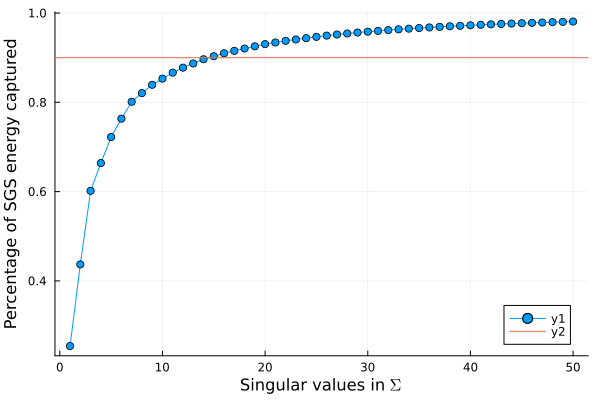

In [8]:
Plots.plot([sum(S[1:i]) for i in 1:size(S)[1]][1:50] ./ sum(S),marker = true)
hline!([0.9])
xlabel!("Singular values in " * L"\Sigma")
ylabel!("Percentage of SGS energy captured")

## Some of the POD modes

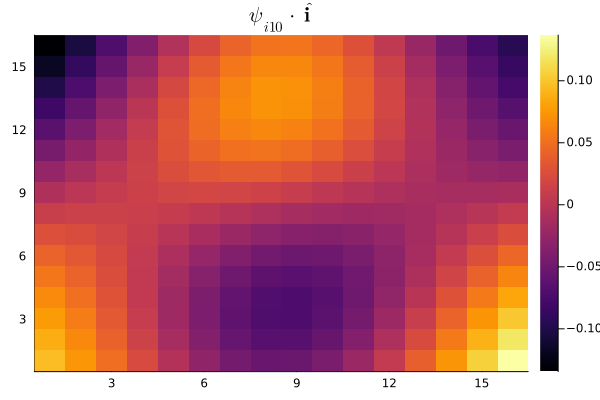

In [9]:
heatmap(POD_modes[:,:,1,8])
title!(L"\psi_{i10} \cdot \hat{\mathbf{i}}")

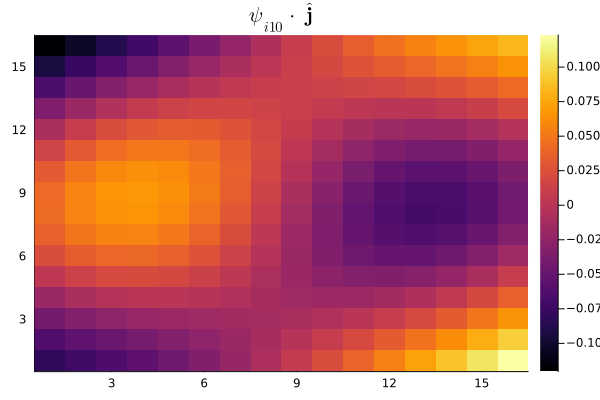

In [10]:
heatmap(POD_modes[:,:,2,8])
title!(L"\psi_{i10} \cdot \hat{\mathbf{j}}")

## Construct projection operators

In [11]:
r =20 #how many modes to include, including V_bar
uniform = true

if conserve_momentum 
    if r >= UPC + 1
        global_POD_modes = local_to_global_modes(POD_modes[[(:) for i in 1:fine_mesh.dims]...,:,1:(r-UPC)],MP)

    else
        global_POD_modes = 0
    end

    global_POD_modes = add_filter_to_modes(global_POD_modes,MP,orthogonalize = !uniform)

else
    global_POD_modes = local_to_global_modes(POD_modes[[(:) for i in 1:fine_mesh.dims]...,:,1:r],MP)
end

PO = gen_projection_operators(global_POD_modes,MP,uniform =uniform)

GC.gc()


In [12]:
function true_W(u,setup,setup_bar,PO)
    
    UPC = setup.mesh.UPC
    dims = setup.mesh.dims

    
    a = PO.W(setup.GS.A_s_c(u))
    
    u_bar_c = a[[(:) for i in 1:dims]...,1:UPC,:]

    u_bar_s = setup_bar.GS.A_c_s(u_bar_c)
    
    r = setup_bar.O.M(padding(u_bar_s,Tuple((1 for i in 1:dims)),circular = true))
    p = setup_bar.PS(r)
    
    Gp = setup_bar.O.G(padding(p,Tuple((1 for i in 1:dims)),circular = true))
    
    u_bar_s -= Gp
    
    return cat(u_bar_s,a[[(:) for i in 1:dims]...,UPC+1:end,:],dims = dims+1)
end

function true_R(a,setup,setup_bar,PO)
    
    UPC = setup.mesh.UPC
    dims = setup.mesh.dims
    
    u_bar_s = a[[(:) for i in 1:dims]...,1:UPC,:]
    
    u_bar_s = setup_bar.GS.A_s_c(u_bar_s)
    
    u_r = setup.GS.A_c_s(PO.R(cat(u_bar_s,a[[(:) for i in 1:dims]...,UPC+1:end,:],dims = dims+1)))
    
    r = setup.O.M(padding(u_r,Tuple((1 for i in 1:dims)),circular = true))
    p = setup.PS(r)

    Gp = setup.O.G(padding(p,Tuple((1 for i in 1:dims)),circular = true))
    
    u_r -= Gp
    
    
    return u_r
end





true_R (generic function with 1 method)

## Project reference data onto POD space

In [13]:
GC.gc()

setup_bar = gen_setup(coarse_mesh)

W(u,setup = setup,setup_bar = setup_bar,PO = PO) = true_W(u,setup,setup_bar,PO)
R(a,setup = setup,setup_bar = setup_bar,PO = PO) = true_R(a,setup,setup_bar,PO)

ref_data = W(data)
data = 0

F_a = W(F)
rhs_bar = gen_rhs(setup_bar,F_a[:,:,1:2,:];Re = 1000)
0

0

## Plot vorticity of reconstructed $\mathbf{u}_r$

[ Info: Saved animation to /home/toby/Projects/Local_POD_NS/DNS_flow.gif


Plots.AnimatedGif("/home/toby/Projects/Local_POD_NS/DNS_flow.gif")
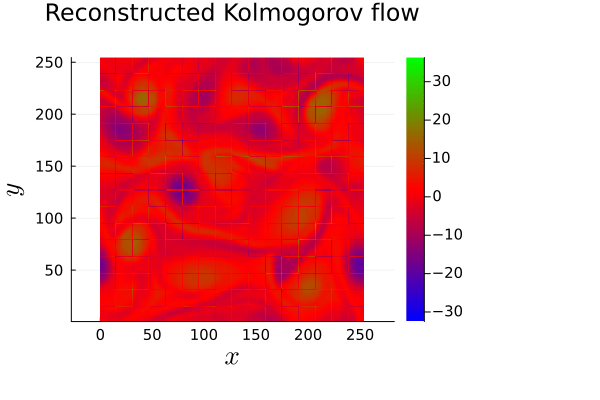

In [14]:
to_plot = setup.O.w(R(ref_data[:,:,:,1:50]))[:,:,1,:]

ymin = minimum(to_plot)
ymax = maximum(to_plot)


anim = @animate for index in 1:size(to_plot)[3]
    Plots.heatmap(to_plot[:,:,index]',color = :brg,clim = (ymin,ymax),yflip=false,xtickfontsize = 10,ytickfontsize = 10
    ,aspect_ratio = :equal,titlefontsize=16,yguidefontsize=18,xguidefontsize=18,title = "Reconstructed Kolmogorov flow",right_margin = 35Plots.mm)
    Plots.xlabel!(L"x")
    Plots.ylabel!(L"y")
    #title!(L"t = " * string(round(example_t[index],digits = 1)))
end
to_plot = 0
gif(anim, "DNS_flow.gif", fps = 30)


# Evolution of the state

We are interested in marching the coefficients $\mathbf{a}$ forward in time:

$$ \frac{\text{d}\mathbf{a}}{\text{d}t} = ????? $$.

One option would be to do a Galerkin projection, however this scales cubically due to the presence of the non-linear term in the Navier-Stokes equations. Also it would be difficult to deal with the algebraic constraint. It is therefore we propose to use our structure-preserving closure modeling framework introduced in https://arxiv.org/abs/2301.13770. This works as follows:

We first obtain $\mathbf{a}\in \mathbb{R}^{rI}$ from a discrete DNS $\mathbf{V} \in \mathbb{R}^{2N}$:

$$ \mathbf{a} = \begin{bmatrix} \bar{\mathbf{V}} \\ \text{SGS modes}  \end{bmatrix}=  \mathbf{P} \mathbf{A}_{c}^s \mathbf{W}\mathbf{V}$$,

where $\mathbf{W}$ is the discretized local POD projection. The first two modes of each coarse grid cell will be referred as $\bar{\mathbf{V}} \in \mathbb{R}^{2I}$ which correspond to the averaged velocity in each direction. We use a staggered grid finite volume implementation for our coarse grid model. We therefore project $\bar{\mathbf{V}}$ onto this staggered grid using the operator $\mathbf{A}_{c}^s \in \mathbb{R}^{rI \times rI}$. In addition we project onto a divergence free basis using the operator $\mathbf{P} \in \mathbb{R}^{rI \times rI}$. Note that these final two operator do not affect the SGS modes of $\mathbf{a}$ but only $\bar{\mathbf{V}}$. The evolution equation is modeled as follows:

$$\frac{\text{d}\mathbf{a}}{\text{d}t} \approx \begin{bmatrix} -\mathbf{C}(\bar{\mathbf{V}})\bar{\mathbf{V}}+\frac{1}{\text{Re}}\mathbf{D}\bar{\mathbf{V}} - \mathbf{G}\bar{\mathbf{p}}\\ \mathbf{0} \end{bmatrix} +\mathbf{A}_{c}^s \text{SP}(\mathbf{A}_{s}^c \mathbf{a}) + \mathbf{P} \mathbf{A}_{c}^s \mathbf{W} \mathbf{F}, \\ 
\mathbf{M}\bar{\mathbf{V}}= 0,$$

where $\mathbf{A}_{s}^c$ projects $\bar{\mathbf{V}}$ onto a cell-centred grid such that it plays nicely with the convolutional neural network contained in our structure-preserving closure $\text{SP}$. For $\bar{\mathbf{V}}$ we also include the coarse discretization. In the absence of forcing this model is strictly dissipative:

$$ \frac{1}{2} \frac{\text{d}\mathbf{a}^T\boldsymbol{\Omega}\mathbf{a}}{\text{d}t} = \mathbf{a}^T\boldsymbol{\Omega}\frac{\text{d}\mathbf{a}}{\text{d}t} = \leq  0.$$

## Define neural network and full framework including phyiscs

In [40]:
kernel_sizes= [(1,1),(1,1)]
channels = [r+2,30] # r+2 as the first channels are the coarse rhs
strides = [(1,1),(1,1)]
B = (1,1)
boundary_padding = "c" #[["c","c"];;[0,0]]


constrain_energy =true # whether to use a physics constrained NN or not
dissipation = true # include dissipation if physics is constrained
conserve_momentum =true # conserve momentum if physics is constrained


model = gen_skew_NN(kernel_sizes,channels,strides,r,B,boundary_padding = boundary_padding,UPC = coarse_mesh.UPC,constrain_energy = constrain_energy,dissipation = dissipation,conserve_momentum = conserve_momentum)
0

0

In [41]:
function neural_rhs(a,mesh,t,rhs = rhs_bar,setup = setup_bar,model = model,F = F_a,B=B,damping = 0.1;other_arguments = 0)
    
    dims = mesh.dims
    
    u_s = a[:,:,1:2,:]
    
    RHS = rhs(u_s,mesh,t,solve_pressure = false)
    
    RHS_c = setup.GS.A_s_c(RHS)
    u_c = setup.GS.A_s_c(u_s)
    
    a_c = cat(u_c,a[:,:,3:end,:],dims = dims+1)
    
    input = cat(RHS_c,a,dims = dims +1)  

    nn_output = model.eval(input,a = padding(a_c,((2*[B...])...,),circular = true))
    
    nn_output = cat(setup.GS.A_c_s(nn_output[:,:,1:2,:]),nn_output[:,:,3:end,:],dims = dims+1)
    
    ### find pressure based on NN_output

    r = setup.O.M(padding(RHS + nn_output[:,:,1:2,:] ,(1,1),circular = true))
    
    p = setup.PS(r)
    
    Gp = setup.O.G(padding(p,(1,1),circular = true))
     
    ####################################
    # include damping from kolmogorov flow
    physics_rhs = cat( RHS -Gp , - damping * a[:,:,3:end,:] .+ F[:,:,3:end,:] ,dims = dims +1) 

    return nn_output +   physics_rhs
    
    
end

neural_rhs (generic function with 7 methods)

## Preprate trajectory fitting

In [46]:
# remove data that lies at the end of the simulation
traj_dt = 0.025
traj_steps = 5

buffer_dt = traj_steps * traj_dt 



simulation_indexes = collect(1:original_shape[end-1])'
simulation_indexes = cat([simulation_indexes for i in 1:original_shape[end]]...,dims = fine_mesh.dims + 2)
simulation_indexes = simulation_indexes[1:end]
simulation_times = t_data[1:end]

ref_data_trajectory = reshape(ref_data,(size(ref_data)[1:coarse_mesh.dims+1]...,original_shape...))
        
#### such that we can interpolate between our snapshots
sim_interpolator = gen_time_interpolator(t_data,ref_data_trajectory)

select = buffer_dt .< maximum(simulation_times) .- simulation_times

traj_data = ref_data[[(:) for i in 1:coarse_mesh.dims+1]...,select]
traj_indexes = simulation_indexes[select]
traj_times = simulation_times[select]


function trajectory_fitting_loss(input,indexes,times,dt = traj_dt,steps = traj_steps,sim_interpolator = sim_interpolator,neural_rhs = neural_rhs,coarse_mesh = coarse_mesh)
    dims = length(size(input)) - 2
    
    t_start = reshape(times,([1 for i in 1:dims+1]...,size(times)[1]))
    t_end =  t_start .+ steps *dt
    t,result = simulate(input,coarse_mesh,dt,t_start,t_end,neural_rhs,time_step,save_every = 1,pre_allocate = false) 
    reference = stop_gradient() do
        sim_interpolator(t,simulation_indexes = indexes)
    end
    return Flux.Losses.mse(result,reference)
end    
    


trajectory_fitting_loss (generic function with 6 methods)

## Evaluate loss for some the snapshots

In [47]:
snapshots_included = 50
select = rand(collect(1:prod(size(traj_indexes))),(snapshots_included))
sqrt.(trajectory_fitting_loss(traj_data[:,:,:,select],traj_indexes[select],traj_times[select]))


0.005560240587769955

# Train model using trajectory fitting

In [48]:
opt = ADAM()

Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [49]:
ps = Flux.params(model.CNN,model.B_mats...)
epochs =50
losses = zeros(epochs)

batchsize = 5

for epoch in tqdm(1:epochs)
    
    ###### Load a subset of the data ######
    select = rand(collect(1:prod(size(traj_indexes))),(snapshots_included))
    trajectory_fitting_data_loader = Flux.Data.DataLoader((traj_data[:,:,:,select],traj_indexes[select],traj_times[select]), batchsize=batchsize,shuffle=true)
    #######################################
    
    Flux.train!(trajectory_fitting_loss,ps, trajectory_fitting_data_loader, opt)
    train_loss = trajectory_fitting_loss(traj_data[:,:,:,select],traj_indexes[select],traj_times[select])
    losses[epoch] = train_loss
    GC.gc()
end

0.0%┣                                               ┫ 0/50 [00:00<00:00, -0s/it]
2.0%┣▉                                          ┫ 1/50 [00:17<Inf:Inf, InfGs/it]
4.0%┣█▉                                             ┫ 2/50 [00:35<27:38, 35s/it]
6.0%┣██▉                                            ┫ 3/50 [00:51<19:49, 25s/it]
8.0%┣███▊                                           ┫ 4/50 [01:06<16:44, 22s/it]
10.0%┣████▋                                         ┫ 5/50 [01:22<15:19, 20s/it]
12.0%┣█████▌                                        ┫ 6/50 [01:39<14:35, 20s/it]
14.0%┣██████▍                                       ┫ 7/50 [01:55<13:42, 19s/it]
16.0%┣███████▍                                      ┫ 8/50 [02:10<12:58, 19s/it]
18.0%┣████████▎                                     ┫ 9/50 [02:27<12:34, 18s/it]
20.0%┣█████████                                    ┫ 10/50 [02:44<12:10, 18s/it]
22.0%┣██████████                                   ┫ 11/50 [02:59<11:39, 18s/it]
24.0%┣██████████▉           

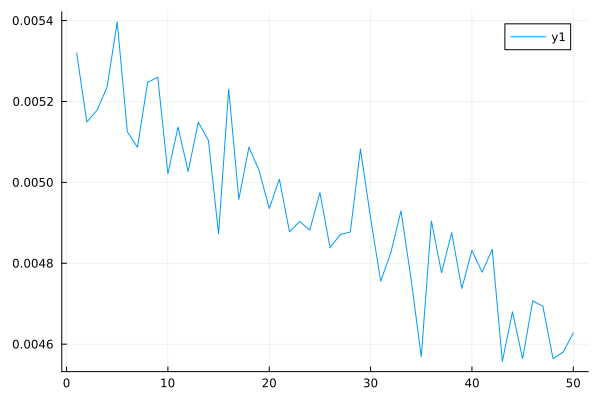

In [50]:
plot(sqrt.(losses))

## Run simulation to test

In [ ]:
t_start = 0
t_end = 100
dt = 0.025
save_every = 2
pre_allocate = true
init_cond = ref_data[:,:,:,1:1]

t,pred_sim = simulate(init_cond,coarse_mesh,dt,t_start,t_end,neural_rhs,time_step,save_every = save_every,pre_allocate = pre_allocate) 
t_pred = t[1:end]
pred_sim = pred_sim[:,:,:,1,:]



0.0%┣                                             ┫ 0/4.0k [00:00<00:00, -0s/it]
0.1%┣                                              ┫ 2/4.0k [00:00<16:19, 4it/s]
0.2%┣                                             ┫ 8/4.0k [00:00<03:01, 22it/s]
0.4%┣▏                                           ┫ 14/4.0k [00:00<01:55, 35it/s]
0.4%┣▏                                           ┫ 18/4.0k [00:00<01:40, 40it/s]
0.6%┣▎                                           ┫ 24/4.0k [00:00<01:24, 47it/s]
0.7%┣▎                                           ┫ 28/4.0k [00:01<01:20, 49it/s]
0.8%┣▍                                           ┫ 33/4.0k [00:01<01:14, 54it/s]
0.9%┣▍                                           ┫ 38/4.0k [00:01<01:10, 57it/s]
1.1%┣▌                                           ┫ 44/4.0k [00:01<01:05, 61it/s]
1.2%┣▌                                           ┫ 49/4.0k [00:01<01:03, 63it/s]
1.4%┣▋                                           ┫ 55/4.0k [00:01<01:00, 66it/s]
1.5%┣▋                      

12.7%┣█████▍                                    ┫ 509/4.0k [00:06<00:41, 84it/s]
12.9%┣█████▍                                    ┫ 515/4.0k [00:06<00:41, 84it/s]
13.0%┣█████▌                                    ┫ 520/4.0k [00:06<00:41, 84it/s]
13.2%┣█████▌                                    ┫ 526/4.0k [00:06<00:41, 85it/s]
13.3%┣█████▋                                    ┫ 531/4.0k [00:06<00:41, 85it/s]
13.4%┣█████▋                                    ┫ 536/4.0k [00:06<00:41, 85it/s]
13.6%┣█████▊                                    ┫ 542/4.0k [00:06<00:41, 85it/s]
13.7%┣█████▊                                    ┫ 547/4.0k [00:06<00:41, 85it/s]
13.8%┣█████▉                                    ┫ 553/4.0k [00:06<00:41, 85it/s]
14.0%┣█████▉                                    ┫ 558/4.0k [00:07<00:40, 85it/s]
14.1%┣██████                                    ┫ 564/4.0k [00:07<00:40, 85it/s]
14.2%┣██████                                    ┫ 569/4.0k [00:07<00:40, 85it/s]
14.3%┣██████                

24.6%┣██████████▍                               ┫ 986/4.0k [00:12<00:37, 82it/s]
24.8%┣██████████▍                               ┫ 991/4.0k [00:12<00:37, 82it/s]
24.9%┣██████████▌                               ┫ 995/4.0k [00:12<00:37, 82it/s]
25.0%┣██████████▎                              ┫ 1.0k/4.0k [00:12<00:37, 82it/s]
25.1%┣██████████▎                              ┫ 1.0k/4.0k [00:12<00:36, 82it/s]
25.2%┣██████████▍                              ┫ 1.0k/4.0k [00:12<00:36, 82it/s]
25.4%┣██████████▍                              ┫ 1.0k/4.0k [00:12<00:36, 82it/s]
25.5%┣██████████▌                              ┫ 1.0k/4.0k [00:12<00:36, 82it/s]
25.6%┣██████████▌                              ┫ 1.0k/4.0k [00:12<00:36, 82it/s]
25.8%┣██████████▋                              ┫ 1.0k/4.0k [00:13<00:36, 82it/s]
25.9%┣██████████▋                              ┫ 1.0k/4.0k [00:13<00:36, 82it/s]
26.0%┣██████████▋                              ┫ 1.0k/4.0k [00:13<00:36, 82it/s]
26.1%┣██████████▊           

35.3%┣██████████████▌                          ┫ 1.4k/4.0k [00:18<00:33, 79it/s]
35.4%┣██████████████▌                          ┫ 1.4k/4.0k [00:18<00:33, 79it/s]
35.5%┣██████████████▋                          ┫ 1.4k/4.0k [00:18<00:33, 79it/s]
35.6%┣██████████████▋                          ┫ 1.4k/4.0k [00:18<00:33, 79it/s]
35.8%┣██████████████▊                          ┫ 1.4k/4.0k [00:18<00:33, 79it/s]
35.9%┣██████████████▊                          ┫ 1.4k/4.0k [00:18<00:33, 79it/s]
36.0%┣██████████████▊                          ┫ 1.4k/4.0k [00:18<00:32, 79it/s]
36.1%┣██████████████▉                          ┫ 1.4k/4.0k [00:18<00:32, 79it/s]
36.2%┣██████████████▉                          ┫ 1.4k/4.0k [00:18<00:32, 79it/s]
36.4%┣███████████████                          ┫ 1.5k/4.0k [00:18<00:32, 79it/s]
36.5%┣███████████████                          ┫ 1.5k/4.0k [00:18<00:32, 79it/s]
36.6%┣███████████████                          ┫ 1.5k/4.0k [00:19<00:32, 79it/s]
36.7%┣███████████████       

46.9%┣███████████████████▎                     ┫ 1.9k/4.0k [00:24<00:27, 79it/s]
47.0%┣███████████████████▎                     ┫ 1.9k/4.0k [00:24<00:27, 79it/s]
47.1%┣███████████████████▎                     ┫ 1.9k/4.0k [00:24<00:27, 79it/s]
47.3%┣███████████████████▍                     ┫ 1.9k/4.0k [00:24<00:27, 79it/s]
47.4%┣███████████████████▍                     ┫ 1.9k/4.0k [00:24<00:27, 79it/s]
47.5%┣███████████████████▌                     ┫ 1.9k/4.0k [00:24<00:27, 79it/s]
47.6%┣███████████████████▌                     ┫ 1.9k/4.0k [00:24<00:27, 79it/s]
47.7%┣███████████████████▋                     ┫ 1.9k/4.0k [00:24<00:27, 79it/s]
47.8%┣███████████████████▋                     ┫ 1.9k/4.0k [00:24<00:26, 79it/s]
47.9%┣███████████████████▋                     ┫ 1.9k/4.0k [00:24<00:26, 79it/s]
48.0%┣███████████████████▊                     ┫ 1.9k/4.0k [00:24<00:26, 79it/s]
48.1%┣███████████████████▊                     ┫ 1.9k/4.0k [00:24<00:26, 79it/s]
48.3%┣███████████████████▉  

59.6%┣████████████████████████▌                ┫ 2.4k/4.0k [00:30<00:20, 81it/s]
59.8%┣████████████████████████▌                ┫ 2.4k/4.0k [00:30<00:20, 81it/s]
59.9%┣████████████████████████▋                ┫ 2.4k/4.0k [00:30<00:20, 81it/s]
60.0%┣████████████████████████▋                ┫ 2.4k/4.0k [00:30<00:20, 81it/s]
60.2%┣████████████████████████▊                ┫ 2.4k/4.0k [00:30<00:20, 81it/s]
60.3%┣████████████████████████▊                ┫ 2.4k/4.0k [00:30<00:20, 81it/s]
60.5%┣████████████████████████▉                ┫ 2.4k/4.0k [00:30<00:20, 81it/s]
60.6%┣████████████████████████▉                ┫ 2.4k/4.0k [00:30<00:20, 81it/s]
60.7%┣█████████████████████████                ┫ 2.4k/4.0k [00:30<00:19, 81it/s]
60.9%┣█████████████████████████                ┫ 2.4k/4.0k [00:30<00:19, 81it/s]
61.0%┣█████████████████████████                ┫ 2.4k/4.0k [00:30<00:19, 81it/s]
61.1%┣█████████████████████████                ┫ 2.4k/4.0k [00:30<00:19, 81it/s]
61.3%┣██████████████████████

## Neural network prediction

In [ ]:
to_plot = setup.O.w(R(pred_sim[:,:,:,1:50]))[:,:,1,:]
#to_plot = setup_bar.O.w(pred_sim[:,:,1:2,:])[:,:,1,:]


ymin = minimum(to_plot)
ymax = maximum(to_plot)


anim = @animate for index in 1:size(to_plot)[3]
    Plots.heatmap(to_plot[:,:,index]',color = :brg,clim = (ymin,ymax),yflip=false,xtickfontsize = 10,ytickfontsize = 10
    ,aspect_ratio = :equal,titlefontsize=16,yguidefontsize=18,xguidefontsize=18,title = "NN prediction",right_margin = 35Plots.mm)
    Plots.xlabel!(L"x")
    Plots.ylabel!(L"y")
    #title!(L"t = " * string(round(example_t[index],digits = 1)))
end

gif(anim, "NN_flow_1.gif", fps = 30)

In [ ]:
to_plot = setup_bar.O.w(pred_sim[:,:,1:2,1:50])[:,:,1,:]
#to_plot = setup_bar.O.w(pred_sim[:,:,1:2,:])[:,:,1,:]


ymin = minimum(to_plot)
ymax = maximum(to_plot)


anim = @animate for index in 1:size(to_plot)[3]
    Plots.heatmap(to_plot[:,:,index]',color = :brg,clim = (ymin,ymax),yflip=false,xtickfontsize = 10,ytickfontsize = 10
    ,aspect_ratio = :equal,titlefontsize=16,yguidefontsize=18,xguidefontsize=18,title = "NN prediction",right_margin = 35Plots.mm)
    Plots.xlabel!(L"x")
    Plots.ylabel!(L"y")
    #title!(L"t = " * string(round(example_t[index],digits = 1)))
end

gif(anim, "NN_flow_2.gif", fps = 30)

## Compare to ground truth

In [ ]:
to_plot = setup.O.w(R(ref_data_trajectory[:,:,:,1,1:50]))[:,:,1,:]
#to_plot = setup_bar.O.w(pred_sim[:,:,1:2,:])[:,:,1,:]


ymin = minimum(to_plot)
ymax = maximum(to_plot)


anim = @animate for index in 1:size(to_plot)[3]
    Plots.heatmap(to_plot[:,:,index]',color = :brg,clim = (ymin,ymax),yflip=false,xtickfontsize = 10,ytickfontsize = 10
    ,aspect_ratio = :equal,titlefontsize=16,yguidefontsize=18,xguidefontsize=18,title = "Ground truth",right_margin = 35Plots.mm)
    Plots.xlabel!(L"x")
    Plots.ylabel!(L"y")
    #title!(L"t = " * string(round(example_t[index],digits = 1)))
end

gif(anim, "DNS_flow.gif", fps = 30)

In [ ]:
plot(t_pred,coarse_mesh.ip(pred_sim,pred_sim)[1:end],label = "NN: " * L"E_r")
plot!(t_data[1:end],coarse_mesh.ip(ref_data_trajectory[:,:,:,1,:],ref_data_trajectory[:,:,:,1,:])[1:end],label = "Ground truth:" * L"E_r")
plot!(t_data[1:end],energies[:,:,:,1,:][1:end],label = L"E")
ylabel!(L"E")
xlabel!(L"t")